# Text Classification with BERT using Pytorch.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install --upgrade "urllib3==1.25.4" awscli

Requirement already up-to-date: urllib3==1.25.4 in /usr/local/lib/python3.6/dist-packages (1.25.4)
Requirement already up-to-date: awscli in /usr/local/lib/python3.6/dist-packages (1.18.190)


In [3]:
!pip install pytorch-transformers

In [4]:
import csv
import os
import random
from pathlib import Path
import numpy as np
import pandas as pd
import torch
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler,
                              TensorDataset)
from torch.utils.data.distributed import DistributedSampler
from pytorch_transformers import BertConfig, BertForSequenceClassification, BertTokenizer
from pytorch_transformers import AdamW, WarmupLinearSchedule
from tqdm import tqdm, trange, tqdm_notebook
from sklearn.metrics import matthews_corrcoef, f1_score

### Loading the Dataset.
I am using a small subset of Amazon Reviews Dataset containing only 10000 rows. You can use the whole dataset but it will take a much longer time to train.

In [5]:
dataset = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Womens Clothing E-Commerce Reviews.csv')
dataset.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [6]:
dataset = dataset.loc[:, ['Review Text', 'Rating']]
dataset.head()

,Review Text,Rating
0,Absolutely wonderful - silky and sexy and comf...,4
1,Love this dress! it's sooo pretty. i happene...,5
2,I had such high hopes for this dress and reall...,3
3,"I love, love, love this jumpsuit. it's fun, fl...",5
4,This shirt is very flattering to all due to th...,5


In [7]:
dataset = dataset.dropna()
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22641 entries, 0 to 23485
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Review Text  22641 non-null  object
 1   Rating       22641 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 530.6+ KB


In [8]:
def get_sentiment(value):
    if value > 3:
        return 1
    else:
        return 0

In [9]:
dataset['Sentiment'] = dataset['Rating'].apply(get_sentiment)
dataset.head()

,Review Text,Rating,Sentiment
0,Absolutely wonderful - silky and sexy and comf...,4,1
1,Love this dress! it's sooo pretty. i happene...,5,1
2,I had such high hopes for this dress and reall...,3,0
3,"I love, love, love this jumpsuit. it's fun, fl...",5,1
4,This shirt is very flattering to all due to th...,5,1


In [10]:
dataset.drop(['Rating'], axis=1, inplace=True)
dataset.head()

,Review Text,Sentiment
0,Absolutely wonderful - silky and sexy and comf...,1
1,Love this dress! it's sooo pretty. i happene...,1
2,I had such high hopes for this dress and reall...,0
3,"I love, love, love this jumpsuit. it's fun, fl...",1
4,This shirt is very flattering to all due to th...,1


In [11]:
np.random.seed(1)
dataset = dataset.sample(frac = 1)

In [12]:
from sklearn.model_selection import train_test_split
# train_df = dataset.iloc[:18500]
# val_df = dataset.iloc[18500:]

# train_df.shape, val_df.shape
train_df, val_df = train_test_split(dataset, test_size=0.5, random_state=101)
val_df, test_df = train_test_split(val_df, test_size=0.5, random_state=101)

train_df.shape, val_df.shape, test_df.shape

((11320, 2), (5660, 2), (5661, 2))

Pytorch-Transformers library requires dataset to be divided in Train, Valid (read Dev) and Test set. In this case I will not be using a Test set.

In [13]:
save_dir = Path('/content/drive/My Drive/Colab Notebooks/Amazon Reviews')
train_df.to_csv(str(save_dir / "train.csv"), index=False)
val_df.to_csv(str(save_dir / "dev.csv"), index=False)
test_df.to_csv(str(save_dir / "test.csv"), index=False)

In [14]:
class InputExample(object):
    """A single training/test example for simple sequence classification."""

    def __init__(self, guid, text_a, text_b=None, label=None):
        """Constructs a InputExample.
        Args:
            guid: Unique id for the example.
            text_a: string. The untokenized text of the first sequence. For single
            sequence tasks, only this sequence must be specified.
            text_b: (Optional) string. The untokenized text of the second sequence.
            Only must be specified for sequence pair tasks.
            label: (Optional) string. The label of the example. This should be
            specified for train and dev examples, but not for test examples.
        """
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label

In [15]:
class InputFeatures(object):
    """A single set of features of data."""

    def __init__(self, input_ids, input_mask, segment_ids, label_id):
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.label_id = label_id

In [16]:
class DataProcessor(object):
    """Base class for data converters for sequence classification data sets."""

    def get_train_examples(self, data_dir):
        """Gets a collection of `InputExample`s for the train set."""
        raise NotImplementedError()

    def get_dev_examples(self, data_dir):
        """Gets a collection of `InputExample`s for the dev set."""
        raise NotImplementedError()

    def get_labels(self):
        """Gets the list of labels for this data set."""
        raise NotImplementedError()

    @classmethod
    def _read_tsv(cls, input_file, quotechar=None):
        """Reads a tab separated value file."""
        with open(input_file, "r", encoding="utf-8-sig") as f:
            reader = csv.reader(f, delimiter="\t", quotechar=quotechar)
            lines = []
            for line in reader:
                if sys.version_info[0] == 2:
                    line = list(unicode(cell, 'utf-8') for cell in line)
                lines.append(line)
            return lines
          
class AmazonProcessor(DataProcessor):
    """Processor for the Amazon Reviews data set."""

    def get_train_examples(self, data_dir):
        """See base class."""
        return self._create_examples(
            self._read_tsv(os.path.join(data_dir, "train.csv")), "train")

    def get_dev_examples(self, data_dir):
        """See base class."""
        return self._create_examples(
            self._read_tsv(os.path.join(data_dir, "dev.csv")), "dev")

    def get_test_examples(self, data_dir):
        """See base class."""
        return self._create_examples(
            self._read_tsv(os.path.join(data_dir, "test.csv")), "test")

    def get_labels(self):
        """See base class."""
        return [0, 1]

    #Hack to be compatible with the existing code in transformers library
    def _read_tsv(self, file_path):
        return pd.read_csv(file_path).values.tolist()

    def _create_examples(self, lines, set_type):
        """Creates examples for the training and dev sets."""
        examples = []
        for (i, line) in enumerate(lines):
            if i == 0:
               continue
            guid = "%s-%s" % (set_type, i)
            text_a = str(line[0])
           # text_b = None
            label = line[1]
            examples.append(
                InputExample(guid=guid, text_a=text_a, text_b=None, label=label))
        return examples

In [17]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

In [18]:
def simple_accuracy(preds, labels):
  return (preds == labels).mean()
  
def acc_and_f1(preds, labels):
  acc = simple_accuracy(preds, labels)
  f1 = f1_score(y_true=labels, y_pred=preds)
  return {
      "acc": acc,
      "f1": f1,
      "acc_and_f1": (acc + f1) / 2,
  }


def f1_macro(preds, labels):
  return f1_score(y_true=labels, y_pred=preds, average='macro')
  
def compute_metrics(task_name, preds, labels):
  assert len(preds) == len(labels)
  if task_name == "amazon":
    return {"acc": simple_accuracy(preds, labels)}
  else:
    raise KeyError(task_name)

In [19]:
def _truncate_seq_pair(tokens_a, tokens_b, max_length):
    """Truncates a sequence pair in place to the maximum length."""

    # This is a simple heuristic which will always truncate the longer sequence
    # one token at a time. This makes more sense than truncating an equal percent
    # of tokens from each, since if one sequence is very short then each token
    # that's truncated likely contains more information than a longer sequence.
    while True:
        total_length = len(tokens_a) + len(tokens_b)
        if total_length <= max_length:
            break
        if len(tokens_a) > len(tokens_b):
            tokens_a.pop()
        else:
            tokens_b.pop()


In [20]:
def convert_examples_to_features(examples, label_list, max_seq_length,
                                 tokenizer, output_mode,
                                 cls_token_at_end=False, pad_on_left=False,
                                 cls_token='[CLS]', sep_token='[SEP]', pad_token=0,
                                 sequence_a_segment_id=0, sequence_b_segment_id=1,
                                 cls_token_segment_id=1, pad_token_segment_id=0,
                                 mask_padding_with_zero=True):
    """ Loads a data file into a list of `InputBatch`s
        `cls_token_at_end` define the location of the CLS token:
            - False (Default, BERT/XLM pattern): [CLS] + A + [SEP] + B + [SEP]
            - True (XLNet/GPT pattern): A + [SEP] + B + [SEP] + [CLS]
        `cls_token_segment_id` define the segment id associated to the CLS token (0 for BERT, 2 for XLNet)
    """

    label_map = {label : i for i, label in enumerate(label_list)}

    features = []
    for (ex_index, example) in enumerate(examples):

        tokens_a = tokenizer.tokenize(example.text_a)

        tokens_b = None
        if example.text_b:
            tokens_b = tokenizer.tokenize(example.text_b)
            # Modifies `tokens_a` and `tokens_b` in place so that the total
            # length is less than the specified length.
            # Account for [CLS], [SEP], [SEP] with "- 3"
            _truncate_seq_pair(tokens_a, tokens_b, max_seq_length - 3)
        else:
            # Account for [CLS] and [SEP] with "- 2"
            if len(tokens_a) > max_seq_length - 2:
                tokens_a = tokens_a[:(max_seq_length - 2)]

        # The convention in BERT is:
        # (a) For sequence pairs:
        #  tokens:   [CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]
        #  type_ids:   0   0  0    0    0     0       0   0   1  1  1  1   1   1
        # (b) For single sequences:
        #  tokens:   [CLS] the dog is hairy . [SEP]
        #  type_ids:   0   0   0   0  0     0   0
        #
        # Where "type_ids" are used to indicate whether this is the first
        # sequence or the second sequence. The embedding vectors for `type=0` and
        # `type=1` were learned during pre-training and are added to the wordpiece
        # embedding vector (and position vector). This is not *strictly* necessary
        # since the [SEP] token unambiguously separates the sequences, but it makes
        # it easier for the model to learn the concept of sequences.
        #
        # For classification tasks, the first vector (corresponding to [CLS]) is
        # used as as the "sentence vector". Note that this only makes sense because
        # the entire model is fine-tuned.
        tokens = tokens_a + [sep_token]
        segment_ids = [sequence_a_segment_id] * len(tokens)

        if tokens_b:
            tokens += tokens_b + [sep_token]
            segment_ids += [sequence_b_segment_id] * (len(tokens_b) + 1)

        if cls_token_at_end:
            tokens = tokens + [cls_token]
            segment_ids = segment_ids + [cls_token_segment_id]
        else:
            tokens = [cls_token] + tokens
            segment_ids = [cls_token_segment_id] + segment_ids

        input_ids = tokenizer.convert_tokens_to_ids(tokens)

        # The mask has 1 for real tokens and 0 for padding tokens. Only real
        # tokens are attended to.
        input_mask = [1 if mask_padding_with_zero else 0] * len(input_ids)

        # Zero-pad up to the sequence length.
        padding_length = max_seq_length - len(input_ids)
        if pad_on_left:
            input_ids = ([pad_token] * padding_length) + input_ids
            input_mask = ([0 if mask_padding_with_zero else 1] * padding_length) + input_mask
            segment_ids = ([pad_token_segment_id] * padding_length) + segment_ids
        else:
            input_ids = input_ids + ([pad_token] * padding_length)
            input_mask = input_mask + ([0 if mask_padding_with_zero else 1] * padding_length)
            segment_ids = segment_ids + ([pad_token_segment_id] * padding_length)

        assert len(input_ids) == max_seq_length
        assert len(input_mask) == max_seq_length
        assert len(segment_ids) == max_seq_length

        if output_mode == "classification":
            label_id = label_map[example.label]
        elif output_mode == "regression":
            label_id = float(example.label)
        else:
            raise KeyError(output_mode)

        features.append(
                InputFeatures(input_ids=input_ids,
                              input_mask=input_mask,
                              segment_ids=segment_ids,
                              label_id=label_id))
    return features

In [21]:
processor = AmazonProcessor()
label_list = processor.get_labels()
num_labels = len(label_list)

In [22]:
config = BertConfig.from_pretrained('bert-base-uncased', num_labels=num_labels)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')

In [23]:
def load_and_cache_examples(tokenizer, dataset='train'):  
  if dataset == "train":
      examples = processor.get_train_examples(data_dir)
  elif dataset == "dev":
      examples = processor.get_dev_examples(data_dir)
  else:
      examples = processor.get_test_examples(data_dir)
  
  features = convert_examples_to_features(examples, label_list, max_seq_length, tokenizer, output_mode,
            cls_token_at_end=False,            # xlnet has a cls token at the end
            cls_token=tokenizer.cls_token,
            sep_token=tokenizer.sep_token,
            cls_token_segment_id=0,
            pad_on_left=False,                 # pad on the left for xlnet
            pad_token_segment_id=0)
  # Convert to Tensors and build dataset
  all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
  all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
  all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
  if output_mode == "classification":
      all_label_ids = torch.tensor([f.label_id for f in features], dtype=torch.long)
  elif output_mode == "regression":
      all_label_ids = torch.tensor([f.label_id for f in features], dtype=torch.float)

  dataset = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)
  return dataset
  

Hyperparameters are from the library. 

In [24]:
output_mode = 'classification'
max_seq_length = 128
batch_size = 8
max_grad_norm = 1.0
gradient_accumulation_steps=2
num_train_epochs=3
weight_decay=0.0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [25]:
learning_rate = 2e-5
adam_epsilon = 1e-8
warmup_steps = 0

In [26]:
def train(train_dataset, model, tokenizer):
  """ Train the model """
  train_sampler = RandomSampler(train_dataset)
  train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)
  t_total = len(train_dataloader) // gradient_accumulation_steps * num_train_epochs
  # Prepare optimizer and schedule (linear warmup and decay)
  no_decay = ['bias', 'LayerNorm.weight']
  optimizer_grouped_parameters = [
      {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': weight_decay},
      {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
      ]
  optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, eps=adam_epsilon)
  scheduler = WarmupLinearSchedule(optimizer, warmup_steps=warmup_steps, t_total=t_total)
  
  global_step = 0
  tr_loss, logging_loss = 0.0, 0.0
  model.zero_grad()
  train_iterator = tqdm_notebook(range(int(num_train_epochs)), desc="Epoch")
  set_seed(42)
  for _ in train_iterator:
    epoch_iterator = tqdm_notebook(train_dataloader, desc="Iteration")
    for step, batch in enumerate(epoch_iterator):
      model.train()
      batch = tuple(t.to(device) for t in batch)
      inputs = {'input_ids':      batch[0],
                'attention_mask': batch[1],
                'token_type_ids': batch[2],
                'labels':         batch[3]}
      outputs = model(**inputs)
      loss = outputs[0]  # model outputs are always tuple in pytorch-transformers (see doc)
      if gradient_accumulation_steps > 1:
        loss = loss / gradient_accumulation_steps
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
      tr_loss += loss.item()
      if (step + 1) % gradient_accumulation_steps == 0:
          scheduler.step()  # Update learning rate schedule
          optimizer.step()
          model.zero_grad()
          global_step += 1
          
          
  return global_step, tr_loss / global_step
      

In [27]:
def evaluate(model, tokenizer, prefix=""):
  results = {}
  eval_dataset = load_and_cache_examples(tokenizer, dataset='dev')
  eval_batch_size = 8
  eval_sampler = SequentialSampler(eval_dataset)
  eval_dataloader = DataLoader(eval_dataset, sampler=eval_sampler, batch_size=eval_batch_size)
  eval_loss = 0.0
  nb_eval_steps = 0
  preds = None
  out_label_ids = None
  for batch in tqdm_notebook(eval_dataloader, desc="Evaluating"):
    model.eval()
    batch = tuple(t.to(device) for t in batch)
    with torch.no_grad():
      inputs = {'input_ids':      batch[0],
                'attention_mask': batch[1],
                'token_type_ids': batch[2],  # XLM don't use segment_ids
                'labels':         batch[3]}
      outputs = model(**inputs)
      tmp_eval_loss, logits = outputs[:2]
      eval_loss += tmp_eval_loss.mean().item()
    
    nb_eval_steps += 1
    if preds is None:
        preds = logits.detach().cpu().numpy()
        out_label_ids = inputs['labels'].detach().cpu().numpy()
    else:
        preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
        out_label_ids = np.append(out_label_ids, inputs['labels'].detach().cpu().numpy(), axis=0)
  eval_loss = eval_loss / nb_eval_steps
  if output_mode == "classification":
      preds = np.argmax(preds, axis=1)
  elif output_mode == "regression":
      preds = np.squeeze(preds)
  result = compute_metrics("amazon", preds, out_label_ids)
  return result, preds, out_label_ids

In [33]:
def train_validation(train_dataset, validation_dataset, model, tokenizer):
  """ Train the model """
  train_sampler = RandomSampler(train_dataset)
  train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)
  t_total = len(train_dataloader) // gradient_accumulation_steps * num_train_epochs
  # Prepare optimizer and schedule (linear warmup and decay)
  no_decay = ['bias', 'LayerNorm.weight']
  optimizer_grouped_parameters = [
      {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': weight_decay},
      {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
      ]
  optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, eps=adam_epsilon)
  scheduler = WarmupLinearSchedule(optimizer, warmup_steps=warmup_steps, t_total=t_total)
  
  global_step = 0
  tr_loss, logging_loss = 0.0, 0.0
  model.zero_grad()

  train_iterator = tqdm_notebook(range(int(num_train_epochs)), desc="Epoch")
  set_seed(42)

  best_accuracy = 0

  for _ in train_iterator:
    preds = None
    epoch_iterator = tqdm_notebook(train_dataloader, desc="Iteration")
    for step, batch in enumerate(epoch_iterator):
      model.train()
      batch = tuple(t.to(device) for t in batch)
      inputs = {'input_ids':      batch[0],
                'attention_mask': batch[1],
                'token_type_ids': None,       # XLM and RoBERTa don't use segment_ids
                'labels':         batch[3]}
      outputs = model(**inputs)
    # add code to calculate the acc
      tmp_eval_loss, logits = outputs[:2]
      if preds is None:
        preds = logits.detach().cpu().numpy()
        out_label_ids = inputs['labels'].detach().cpu().numpy()
      else:
        preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
        out_label_ids = np.append(out_label_ids, inputs['labels'].detach().cpu().numpy(), axis=0)

      loss = outputs[0]  # model outputs are always tuple in pytorch-transformers (see doc)
      if gradient_accumulation_steps > 1:
        loss = loss / gradient_accumulation_steps
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
      tr_loss += loss.item()
      if (step + 1) % gradient_accumulation_steps == 0:
          scheduler.step()  # Update learning rate schedule
          optimizer.step()
          model.zero_grad()
          global_step += 1
    if output_mode == "classification":
      preds = np.argmax(preds, axis=1)
    elif output_mode == "regression":
      preds = np.squeeze(preds)
    result = compute_metrics("amazon", preds, out_label_ids)
    train_acc = result['acc']
    print(f'the train accuracy is {train_acc}')
    val_result, preds, out_label_ids, preds_p = evaluate_updated(validation_dataset, model, tokenizer, prefix=global_step)
    val_acc = val_result['acc']
    print(f'the validation accuracy is {val_acc}')

    if  val_acc > best_accuracy:
      best_accuracy = val_acc
      model_save_dir = '/content/drive/My Drive/Colab Notebooks/Amazon Reviews/Models/'
      if not os.path.exists(model_save_dir):
        os.mkdir(model_save_dir)
      torch.save(model.state_dict(), os.path.join(model_save_dir, 'best_model.pt'))

  return global_step, tr_loss / global_step, result

In [29]:
def evaluate_updated(dataset, model, tokenizer, prefix=""):
  results = {}
  # eval_dataset = load_and_cache_examples(tokenizer, dataset='dev')
  eval_dataset = dataset
  eval_batch_size = 8
  eval_sampler = SequentialSampler(eval_dataset)
  eval_dataloader = DataLoader(eval_dataset, sampler=eval_sampler, batch_size=eval_batch_size)
  eval_loss = 0.0
  nb_eval_steps = 0
  preds = None
  out_label_ids = None
  for batch in tqdm_notebook(eval_dataloader, desc="Evaluating"):
    model.eval()
    batch = tuple(t.to(device) for t in batch)
    with torch.no_grad():
      inputs = {'input_ids':      batch[0],
                'attention_mask': batch[1],
                'token_type_ids': None,             # XLM and RoBERTa don't use segment_ids
                'labels':         batch[3]}
      outputs = model(**inputs)
      tmp_eval_loss, logits = outputs[:2]
      eval_loss += tmp_eval_loss.mean().item()
    
    nb_eval_steps += 1
    if preds is None:
        preds = logits.detach().cpu().numpy()
        preds_p = sigmoid(preds)
        out_label_ids = inputs['labels'].detach().cpu().numpy()
    else:
        preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
        out_label_ids = np.append(out_label_ids, inputs['labels'].detach().cpu().numpy(), axis=0)
        temp = logits.detach().cpu().numpy()
        preds_p = np.append(preds_p,sigmoid(temp),axis = 0)
  eval_loss = eval_loss / nb_eval_steps
  if output_mode == "classification":
      preds = np.argmax(preds, axis=1)
  elif output_mode == "regression":
      preds = np.squeeze(preds)
  result = compute_metrics("amazon", preds, out_label_ids)
  return result, preds, out_label_ids, preds_p

In [30]:
def sigmoid(x):
  z = 1/(1 + np.exp(-x))
  return z

### Train the Model

In [34]:
data_dir= '/content/drive/My Drive/Colab Notebooks/Amazon Reviews'
model.to(device)
train_dataset = load_and_cache_examples(tokenizer, dataset="train")
validation_dataset = load_and_cache_examples(tokenizer, dataset="dev")
global_step, tr_loss, result = train_validation(train_dataset, validation_dataset, model, tokenizer)
print(result)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)



the train accuracy is 0.974997791324322


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':



the validation accuracy is 0.9065205866760911



the train accuracy is 0.969255234561357



the validation accuracy is 0.9137656829828592



the train accuracy is 0.9877197632299674



the validation accuracy is 0.9112917476585969

{'acc': 0.9877197632299674}


### Evaluate the Model

In [35]:
# Evaluation
test_dataset = load_and_cache_examples(tokenizer, dataset="test")
result, y_preds, labels, preds_p = evaluate_updated(test_dataset, model, tokenizer, prefix="")
print(f"The accuray of BERT classification is {result['acc']*100:.2f}%.")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':



The accuray of BERT classification is 90.60%.


In [36]:
print(len(preds_p))

5660


In [38]:
row_index = [i for i in range(len(preds_p))]
df = pd.DataFrame(data=preds_p, index=row_index, columns=["pred_0", "pred_1"])
df.to_csv('/content/preds_prob.csv')

[Text(0, 0.5, 'Negative'), Text(0, 1.5, 'Positive')]

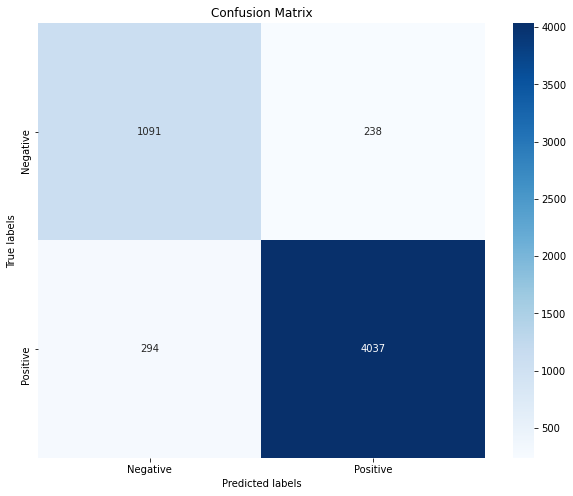

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(labels, y_preds)
fig, ax= plt.subplots(figsize=(10,8))
sns.heatmap(cm, annot=True, ax = ax, cmap=plt.cm.Blues, fmt='g'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix') 
ax.xaxis.set_ticklabels(['Negative', 'Positive']); ax.yaxis.set_ticklabels(['Negative', 'Positive'])

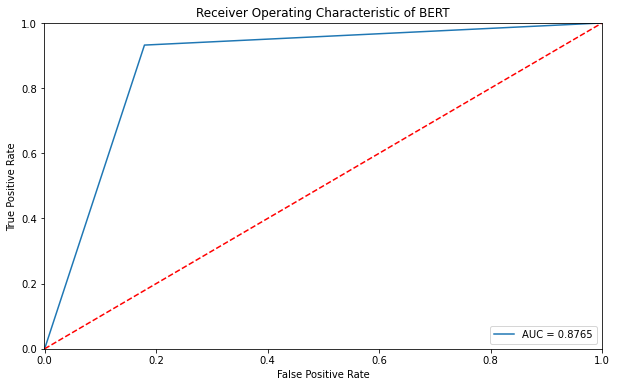

In [40]:
from sklearn.metrics import auc, roc_curve

fpr, tpr, thresholds = roc_curve(labels, y_preds)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10,6))
plt.title('Receiver Operating Characteristic of BERT')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();